
Training a Classifier
=====================

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

1. Loading and normalizing CIFAR10
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Using ``torchvision``, it’s extremely easy to load CIFAR10.



In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [2]:
#変換処理をまとめることができる
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


ここで使われているAPIの説明は以下の通り

In [3]:
transforms.Compose?

Init signature: transforms.Compose(transforms)
Docstring:     
Composes several transforms together. This transform does not support torchscript.
Please, see the note below.

Args:
    transforms (list of ``Transform`` objects): list of transforms to compose.

Example:
    >>> transforms.Compose([
    >>>     transforms.CenterCrop(10),
    >>>     transforms.PILToTensor(),
    >>>     transforms.ConvertImageDtype(torch.float),
    >>> ])

.. note::
    In order to script the transformations, please use ``torch.nn.Sequential`` as below.

    >>> transforms = torch.nn.Sequential(
    >>>     transforms.CenterCrop(10),
    >>>     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    >>> )
    >>> scripted_transforms = torch.jit.script(transforms)

    Make sure to use only scriptable transformations, i.e. that work with ``torch.Tensor``, does not require
    `lambda` functions or ``PIL.Image``.
File:           ~/.pyenv/versions/3.10.5/lib/python3.10/site-packages/torchv

In [4]:
transforms.ToTensor?

Init signature: transforms.ToTensor() -> None
Docstring:     
Convert a ``PIL Image`` or ``numpy.ndarray`` to tensor. This transform does not support torchscript.

Converts a PIL Image or numpy.ndarray (H x W x C) in the range
[0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
if the PIL Image belongs to one of the modes (L, LA, P, I, F, RGB, YCbCr, RGBA, CMYK, 1)
or if the numpy.ndarray has dtype = np.uint8

In the other cases, tensors are returned without scaling.

.. note::
    Because the input image is scaled to [0.0, 1.0], this transformation should not be used when
    transforming target image masks. See the `references`_ for implementing the transforms for image masks.

.. _references: https://github.com/pytorch/vision/tree/main/references/segmentation
File:           ~/.pyenv/versions/3.10.5/lib/python3.10/site-packages/torchvision/transforms/transforms.py
Type:           type
Subclasses:     


In [5]:
transforms.Normalize?

Init signature: transforms.Normalize(mean, std, inplace=False)
Docstring:     
Normalize a tensor image with mean and standard deviation.
This transform does not support PIL Image.
Given mean: ``(mean[1],...,mean[n])`` and std: ``(std[1],..,std[n])`` for ``n``
channels, this transform will normalize each channel of the input
``torch.*Tensor`` i.e.,
``output[channel] = (input[channel] - mean[channel]) / std[channel]``

.. note::
    This transform acts out of place, i.e., it does not mutate the input tensor.

Args:
    mean (sequence): Sequence of means for each channel.
    std (sequence): Sequence of standard deviations for each channel.
    inplace(bool,optional): Bool to make this operation in-place.
Init docstring: Initializes internal Module state, shared by both nn.Module and ScriptModule.
File:           ~/.pyenv/versions/3.10.5/lib/python3.10/site-packages/torchvision/transforms/transforms.py
Type:           type
Subclasses:     


In [6]:
torchvision.datasets.CIFAR10?

Init signature:
torchvision.datasets.CIFAR10(
    root: str,
    train: bool = True,
    transform: Optional[Callable] = None,
    target_transform: Optional[Callable] = None,
    download: bool = False,
) -> None
Docstring:     
`CIFAR10 <https://www.cs.toronto.edu/~kriz/cifar.html>`_ Dataset.

Args:
    root (string): Root directory of dataset where directory
        ``cifar-10-batches-py`` exists or will be saved to if download is set to True.
    train (bool, optional): If True, creates dataset from training set, otherwise
        creates from test set.
    transform (callable, optional): A function/transform that takes in an PIL image
        and returns a transformed version. E.g, ``transforms.RandomCrop``
    target_transform (callable, optional): A function/transform that takes in the
        target and transforms it.
    download (bool, optional): If true, downloads the dataset from the internet and
        puts it in root directory. If dataset is already downloaded, it is not

In [7]:
torch.utils.data.DataLoader?

Init signature:
torch.utils.data.DataLoader(
    dataset: torch.utils.data.dataset.Dataset[+T_co],
    batch_size: Optional[int] = 1,
    shuffle: bool = False,
    sampler: Union[torch.utils.data.sampler.Sampler, Iterable, NoneType] = None,
    batch_sampler: Union[torch.utils.data.sampler.Sampler[Sequence], Iterable[Sequence], NoneType] = None,
    num_workers: int = 0,
    collate_fn: Optional[Callable[[List[~T]], Any]] = None,
    pin_memory: bool = False,
    drop_last: bool = False,
    timeout: float = 0,
    worker_init_fn: Optional[Callable[[int], NoneType]] = None,
    multiprocessing_context=None,
    generator=None,
    *,
    prefetch_factor: int = 2,
    persistent_workers: bool = False,
)
Docstring:     
Data loader. Combines a dataset and a sampler, and provides an iterable over
the given dataset.

The :class:`~torch.utils.data.DataLoader` supports both map-style and
iterable-style datasets with single- or multi-process loading, customizing
loading order and optional au

Let us show some of the training images, for fun.



truck  ship   car  frog


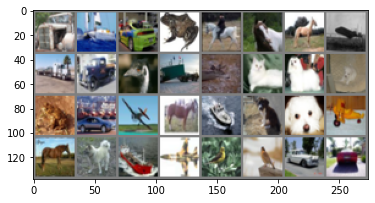

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline 
#jupyter labでは必要ない?
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

2. Define a Convolution Neural Network

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [9]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    #ネットワークの定義
    def __init__(self):
        super(Net, self).__init__() #ここまでおまじない
        #インスタンスの生成
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        """
        順伝搬の定義
        """
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x #出力は10次元


net = Net() #インスタンスの生成
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

3. Define a Loss function and optimizer

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [10]:
import torch.optim as optim

#評価指標と最適化手法の定義
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

4. Train the network

^^^^^^^^^^^^^^^^^^^^

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [11]:
for epoch in range(10):  # loop over the dataset multiple times
    print(f"epoch:{epoch+1}")
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        #trainloaderはyeildで返すイテラブルオブジェクト
        # get the inputs
        inputs, labels = data
        inputs=inputs.to(device)
        labels=labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward() #lossに関して微分しますよ
        optimizer.step() #宣言したオプティマイザで各変数の勾配をとって更新

        # print statistics
        running_loss += loss.item() #2000画像のロスの合計
        if i % 500 == 499:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0 #ロスを表示したら0にリセットして次のlossに備える

print('Finished Training')

epoch:1
[1,   500] loss: 0.574
[1,  1000] loss: 0.558
[1,  1500] loss: 0.511
epoch:2
[2,   500] loss: 0.476
[2,  1000] loss: 0.446
[2,  1500] loss: 0.423
epoch:3
[3,   500] loss: 0.405
[3,  1000] loss: 0.397
[3,  1500] loss: 0.386
epoch:4
[4,   500] loss: 0.371
[4,  1000] loss: 0.366
[4,  1500] loss: 0.355
epoch:5
[5,   500] loss: 0.349
[5,  1000] loss: 0.345
[5,  1500] loss: 0.332
epoch:6
[6,   500] loss: 0.330
[6,  1000] loss: 0.323
[6,  1500] loss: 0.319
epoch:7
[7,   500] loss: 0.310
[7,  1000] loss: 0.311
[7,  1500] loss: 0.302
epoch:8
[8,   500] loss: 0.300
[8,  1000] loss: 0.294
[8,  1500] loss: 0.292
epoch:9
[9,   500] loss: 0.285
[9,  1000] loss: 0.285
[9,  1500] loss: 0.286
epoch:10
[10,   500] loss: 0.279
[10,  1000] loss: 0.277
[10,  1500] loss: 0.271
Finished Training


5. Test the network on the test data

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



GroundTruth:    cat  ship  ship plane


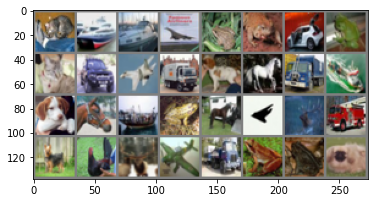

In [12]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [13]:
torchvision.utils.make_grid?

Signature:
torchvision.utils.make_grid(
    tensor: Union[torch.Tensor, List[torch.Tensor]],
    nrow: int = 8,
    padding: int = 2,
    normalize: bool = False,
    value_range: Optional[Tuple[int, int]] = None,
    scale_each: bool = False,
    pad_value: float = 0.0,
    **kwargs,
) -> torch.Tensor
Docstring:
Make a grid of images.

Args:
    tensor (Tensor or list): 4D mini-batch Tensor of shape (B x C x H x W)
        or a list of images all of the same size.
    nrow (int, optional): Number of images displayed in each row of the grid.
        The final grid size is ``(B / nrow, nrow)``. Default: ``8``.
    padding (int, optional): amount of padding. Default: ``2``.
    normalize (bool, optional): If True, shift the image to the range (0, 1),
        by the min and max values specified by ``value_range``. Default: ``False``.
    value_range (tuple, optional): tuple (min, max) where min and max are numbers,
        then these numbers are used to normalize the image. By default, mi

Okay, now let us see what the neural network thinks these examples above are:



In [14]:
outputs = net(images.to(device))
outputs

tensor([[-9.0504e-01, -2.5236e+00,  9.9596e-01,  3.0687e+00,  2.7983e-01,
          2.8098e+00,  1.2324e+00, -1.2599e+00, -5.0044e-02, -2.9820e+00],
        [ 5.7648e+00,  5.9275e+00, -1.8805e+00, -3.2080e+00, -2.8938e+00,
         -5.3663e+00, -4.1343e+00, -4.6005e+00,  4.6575e+00,  3.5914e+00],
        [ 1.5240e+00,  3.8204e+00, -1.5312e+00, -1.2123e+00, -2.6529e+00,
         -2.1736e+00, -1.5344e+00, -2.8542e+00,  2.9208e+00,  3.4013e+00],
        [ 3.4845e+00,  9.0305e-01, -7.7994e-03, -1.7984e+00, -2.0895e-01,
         -3.5693e+00, -1.2962e+00, -2.1686e+00,  4.2637e+00,  3.9594e-01],
        [-1.9748e+00, -1.7907e+00,  1.8289e+00,  1.6722e+00,  3.9345e+00,
          1.0779e+00,  4.1624e+00, -2.1764e+00, -2.0805e+00, -3.7134e+00],
        [-9.7478e-01, -3.6902e-01,  4.4787e-01,  3.7194e-01,  1.0437e+00,
          1.5583e-01,  3.4536e+00, -9.8747e-01, -2.2494e+00, -3.9673e-01],
        [ 1.5097e+00,  4.6042e+00,  3.9883e-01,  5.6950e-01, -3.4504e+00,
         -3.5472e-01,  4.8725e-0

The outputs are energies for the 10 classes.
Higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [15]:
_, predicted = torch.max(outputs, 1)
"""
Example::

    >>> a = torch.randn(4, 4)
    >>> a
    tensor([[-1.2360, -0.2942, -0.1222,  0.8475],
            [ 1.1949, -1.1127, -2.2379, -0.6702],
            [ 1.5717, -0.9207,  0.1297, -1.8768],
            [-0.6172,  1.0036, -0.6060, -0.2432]])
    >>> torch.max(a, 1)
    (tensor([ 0.8475,  1.1949,  1.5717,  1.0036]), tensor([ 3,  0,  0,  1]))
"""

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat   car   car  ship


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [16]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images=images.to(device)
        labels=labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 59 %


That looks waaay better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [17]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad(): #gradを無いものとして扱う
    for data in testloader:
        images, labels = data
        images=images.to(device)
        labels=labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze() #squeezeのは働きがよくわからんけど
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item() #クラスが正しかったら加算していく
            class_total[label] += 1 #そのクラスがトータルで何回出現したか


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 68 %
Accuracy of   car : 85 %
Accuracy of  bird : 38 %
Accuracy of   cat : 33 %
Accuracy of  deer : 39 %
Accuracy of   dog : 53 %
Accuracy of  frog : 71 %
Accuracy of horse : 64 %
Accuracy of  ship : 64 %
Accuracy of truck : 64 %


In [18]:
(predicted==label).squeeze() #外しても変わらないしよくわからない

tensor([False, False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False], device='cuda:1')

Okay, so what next?

How do we run these neural networks on the GPU?

Training on GPU
----------------
Just like how you transfer a Tensor on to the GPU, you transfer the neural
net onto the GPU.

Let's first define our device as the first visible cuda device if we have
CUDA available:



In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assume that we are on a CUDA machine, then this should print a CUDA device:

print(device)

cuda:0


The rest of this section assumes that `device` is a CUDA device.

Then these methods will recursively go over all modules and convert their
parameters and buffers to CUDA tensors:

.. code:: python

    net.to(device)


Remember that you will have to send the inputs and targets at every step
to the GPU too:

.. code:: python

        inputs, labels = inputs.to(device), labels.to(device)

Why dont I notice MASSIVE speedup compared to CPU? Because your network
is realllly small.

**Exercise:** Try increasing the width of your network (argument 2 of
the first ``nn.Conv2d``, and argument 1 of the second ``nn.Conv2d`` –
they need to be the same number), see what kind of speedup you get.

**Goals achieved**:

- Understanding PyTorch's Tensor library and neural networks at a high level.
- Train a small neural network to classify images

Training on multiple GPUs
-------------------------
If you want to see even more MASSIVE speedup using all of your GPUs,
please check out :doc:`data_parallel_tutorial`.

Where do I go next?
-------------------

-  :doc:`Train neural nets to play video games </intermediate/reinforcement_q_learning>`
-  `Train a state-of-the-art ResNet network on imagenet`_
-  `Train a face generator using Generative Adversarial Networks`_
-  `Train a word-level language model using Recurrent LSTM networks`_
-  `More examples`_
-  `More tutorials`_
-  `Discuss PyTorch on the Forums`_
-  `Chat with other users on Slack`_


